# Setting up Colab environment

In [ ]:
import os
username = 'SkoltechAI'
repo = 'Recommender-Systems-Intro-Sber-2022'

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{username}/{repo}.git

In [ ]:
!git clone https://github.com/evfro/cofida.git
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

In [123]:
from typing import List
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex

from cofida.datasets import observations_loader, UserBatchDataset

# navigating to cloned repo directory in Colab
%cd {repo} 
from dataprep import transform_indices, matrix_from_data
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items
# restoring original location
%cd -

In [28]:
def fix_torch_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Preparing data

In [29]:
mldata = get_movielens_data(include_time=True)

In [30]:
test_timepoint = mldata['timestamp'].quantile(
    q=0.95, interpolation='nearest'
)

In [31]:
test_data_ = mldata.query('timestamp >= @test_timepoint')

In [32]:
test_data_.nunique()

userid         813
movieid       3249
rating           5
timestamp    33729
dtype: int64

In [33]:
train_data_ = mldata.query(
    'userid not in @test_data_.userid.unique() and timestamp < @test_timepoint'
)

In [34]:
training, data_index = transform_indices(train_data_.copy(), 'userid', 'movieid')

In [35]:
test_data = reindex(test_data_, data_index['items'])

Filtered 64 invalid observations.


In [36]:
test_data.nunique()

userid         813
movieid       3220
rating           5
timestamp    33678
dtype: int64

We sample the last item for each test user.  
As all these users are excluded from the training, and training is additionally filtered by timestamp,
there will be no "recommendation from future" issue - our model is unaware of future correlations.


In [37]:
testset_, holdout_ = leave_one_out(
    test_data, target='timestamp', sample_top=True, random_state=0
)
testset_valid_, holdout_valid_ = leave_one_out(
    testset_, target='timestamp', sample_top=True, random_state=0
)

Let's focus on validation part.

Int64Index([  20,   23,   36,   44,   59,   65,   74,   89,   90,   99,
            ...
            5956, 5972, 5991, 5995, 5996, 5998, 6001, 6002, 6016, 6040],
           dtype='int64', length=750)

In [83]:
userid = data_index['users'].name
test_users = pd.Index(
    np.intersect1d(
        testset_valid_[userid].unique(),
        holdout_valid_[userid].unique()
    )
)
testset_valid = (
    testset_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)
holdout_valid = (
    holdout_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)

In [78]:
testset_valid.nunique()

userid         750
movieid       3202
rating           5
timestamp    32400
dtype: int64

In [79]:
holdout_valid.shape

(750, 4)

In [80]:
assert holdout_valid.set_index('userid')['timestamp'].ge(
    testset_valid
    .groupby('userid')
    ['timestamp'].max()
).all()

In [81]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
)
data_description

{'users': 'userid',
 'items': 'movieid',
 'feedback': 'rating',
 'n_users': 5227,
 'n_items': 3652}

# User-batch Dataloader

Unlike the MF case, where you worked on a per observations sample in a batch, here you'll need to adapt to a per-user batch sampling strategy. You can write your on sampler, or reuse some predefined ones. Below is an example based on the `cofida` package. 

In [42]:
batch_size = 128

In [47]:
train_loader = observations_loader(
    observations = matrix_from_data(training, data_description),
    batch_size = batch_size, # number of users in the batch
    shuffle = True, # return user batches in random order
    data_factory = UserBatchDataset,
    sparse_batch = True  # can use .to_dense on a batch for calculations
)

In [48]:
batch = next(iter(train_loader))
batch

tensor(indices=tensor([[  32,   32,   32,  ...,  105,  105,  105],
                       [   1,    6,    9,  ..., 3410, 3421, 3431]]),
       values=tensor([1., 4., 4.,  ..., 3., 3., 5.]),
       device='cuda:0', size=(128, 3652), nnz=17372, layout=torch.sparse_coo)

# Single-layer Autoencoder

In [21]:
class AutoEncoderSL(nn.Module):
    def __init__(self, num_items, latent_dim, bias=True):
        super().__init__()

        self.encode = nn.Sequential(
            nn.Linear(num_items, latent_dim, bias=bias),
            nn.Tanh()
        )
        self.decode = nn.Linear(latent_dim, num_items, bias=bias)
    
    def forward(self, x):
        return self.decode(self.encode(x))

## Training

In [52]:
def prepare_ae_model(config, data_description):
    model = AutoEncoderSL(
        data_description['n_items'],
        config['dim']
    )
    # transfer model to GPU if available
    device = None
    if torch.cuda.is_available():
        if not next(model.parameters()).is_cuda:
            model = model.cuda()
        device = next(model.parameters()).device
    # define loss function    
    criterion = torch.nn.BCEWithLogitsLoss().to(device)
    # alternatively: criterion = nn.MSELoss().to(device)
    # define optimizer
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr = config['learning_rate'],
        weight_decay = config['l2_reg']
    )    
    return model, criterion, optimizer, device

In [53]:
def train_ae_epoch(loader, model, criterion, optimizer, scheduler=None, masked_loss=False):
    model.train()
    losses = []
    for batch in loader:
        optimizer.zero_grad()
        dense_batch = batch.to_dense()
        predictions = model(dense_batch)

        if masked_loss:
            mask = dense_batch > 0
            loss = criterion(predictions.masked_select(mask), dense_batch.masked_select(mask))
        else:
            loss = criterion(predictions, dense_batch)

        loss = criterion(predictions, dense_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    if scheduler is not None:
        scheduler.step()
    return losses

In [54]:
def build_ae_model(config, data, data_description):
    '''Simple MF training routine without early stopping'''
    model, criterion, optimizer, device = prepare_ae_model(config, data_description)
    loader = observations_loader(
        observations = matrix_from_data(data, data_description),
        batch_size = batch_size, # number of users in the batch
        shuffle = True, # return user batches in random order
        data_factory = UserBatchDataset,
        sparse_batch = True  # can use .to_dense on a batch for calculations
    )
    losses = {}
    for epoch in tqdm(range(config['epochs'])):
        losses[epoch] = train_ae_epoch(
            loader, model, criterion, optimizer, masked_loss=config['masked_loss']
        )
    return model, losses

In [130]:
config = dict(
    dim = 64,
    learning_rate = 1e-2,
    epochs = 100,
    l2_reg = 0, # L2 regularization
    masked_loss = True
)

In [131]:
ae_model, ae_losses = build_ae_model(config, training, data_description)

100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


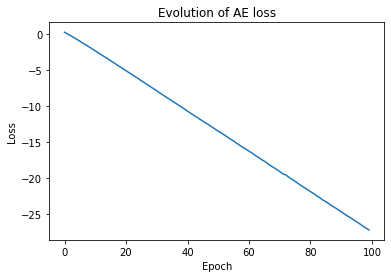

In [132]:
pd.Series(ae_losses).apply(np.mean).plot(title='Evolution of AE loss', xlabel='Epoch', ylabel='Loss');

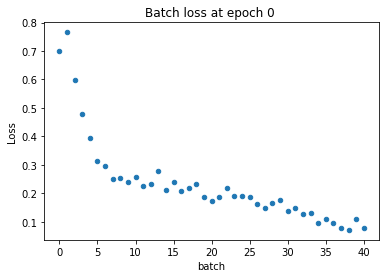

In [133]:
epoch = 0
epoch_loss_series = pd.Series(ae_losses[epoch], name='Loss').rename_axis('batch')
ax = epoch_loss_series.reset_index().plot.scatter(
    x='batch', y='Loss', title=f'Batch loss at epoch {epoch} '
)

## Scoring

In [134]:
def ae_model_scoring(params, data, data_description):
    model = params
    model.eval()
    # prepare user and item index for scoring
    test_matrix = matrix_from_data(
        data,
        # need to account for the warm-users -> they have new index
        # hence, the shape of matrix needs to be set appropriately:
        {**data_description, 'n_users': holdout_valid.shape[0]}
    )
    loader = observations_loader(
        observations = test_matrix,
        batch_size = batch_size, # number of users in the batch
        shuffle = False, # preserve order to ensure alignment with holdout
        data_factory = UserBatchDataset,
        sparse_batch = True  # can use .to_dense on a batch for calculations
    )
    # perform scoring on a user-batch level
    scores = []
    for user_batch in loader:
        dense_batch = user_batch.to_dense()
        with torch.no_grad():
            predictions = model(dense_batch)
        scores.append(predictions.detach().cpu().numpy())
    return np.concatenate(scores, axis=0)

In [135]:
ae_scores = ae_model_scoring(ae_model, testset_valid, data_description)

In [136]:
downvote_seen_items(ae_scores, testset_valid, data_description)

In [137]:
ae_recs = topn_recommendations(ae_scores, topn=10)
model_evaluate(ae_recs, holdout_valid, data_description)

(0.021333333333333333, 0.009012698412698413, 0.1541621029572837)

Vanilla Autoencoders typically perform poorly. To make it work better, one may go several ways.

1. Use more complex models, e.g. MultVAE [Liang et al. 2018] or RecVAE [Shenbin et al. 2019].
2. Use better representation, e.g. hyperbolic geometry [Mirvakhabova and Frolov et al. 2020].

However, even much simpler models like EASEr may provide comparable quality [Steck 2019].

# Example of MultVAE model definition

Source code adapted form https://github.com/postBG/VAE4REC.pytorch

In [129]:
class Decoder(nn.Module):
    def __init__(self, p_dims: List[int], dropout: List[float]):
        super().__init__()

        decoder_layers = []
        for i, (p, inp, out) in enumerate(zip(dropout, p_dims[:-1], p_dims[1:])):
            decoder_layers.append(f'dropout_{i}', nn.Dropout(p))
            decoder_layers.append(f'linear_{i}', nn.Linear(inp, out))
        self.p_layers = nn.Sequential(*decoder_layers)

    def forward(self, X):
        h = X
        n_layers = len(self.p_layers)
        for i, layer in enumerate(self.p_layers, start=1):
            h = layer(h)
            if i < n_layers:
                h = torch.tanh(h)
        return h


class VAEEncoder(nn.Module):
    def __init__(self, q_dims: List[int], dropout: List[float]):
        super().__init__()

        self.q_dims = q_dims
        q_dims_ = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        encoder_layers = []
        for i, (p, inp, out) in enumerate(zip(dropout, q_dims_[:-1], q_dims_[1:])):
            encoder_layers.append(f'dropout_{i}', nn.Dropout(p))
            encoder_layers.append(f'linear_{i}', nn.Linear(inp, out))
        self.q_layers = nn.Sequential(*encoder_layers)

    def forward(self, X):
        h = F.normalize(X, p=2, dim=1)
        n_layers = len(self.q_layers)
        for i, layer in enumerate(self.q_layers, start=1):
            h = layer(h)
            if i < n_layers:
                h = torch.tanh(h)
            else:
                mu, logvar = torch.split(h, self.q_dims[-1], dim=1)
        return mu, logvar


class MultiVAE(nn.Module):
    def __init__(
        self,
        p_dims: List[int],
        q_dims: List[int],
        dropout_enc: List[float],
        dropout_dec: List[float],
    ):
        super().__init__()

        self.encode = VAEEncoder(q_dims, dropout_enc)
        self.decode = Decoder(p_dims, dropout_dec)

    def forward(self, X):
        mu, logvar = self.encode(X)
        sampled = mu
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            sampled = sampled + eps * std
        return self.decode(sampled), mu, logvar
